In [2]:
# Bibliotecas Básicas
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

# FrameWork utilizado --> Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Função para calculo de estatisticas de eficiencia
from sklearn.metrics import classification_report

# Pegando o Dataset pelo Keras
from keras.datasets import mnist

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Analise exploratoria dos dados

In [3]:
print('X_train: ' , train_X.shape)
print('Y_train: ', (train_y.shape))
print('X_test:  ', (test_X.shape))
print('Y_test:  ', test_y.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


Nessa database Tem-se um total de 70000 imagens de números, os quais serao separados 60000 para treinar o modelo e 10000 para testar o modelo treinado.

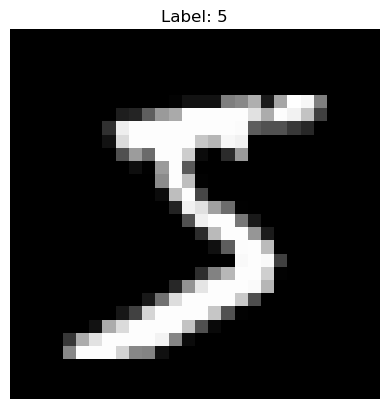

In [4]:

index = 0  # Escolha o índice da imagem que deseja visualizar
image = train_X[index]
label = train_y[index]

# Plotar a imagem
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

Cada Imagem é no formato 28x28 e cada celula tem uma 'tonalidade' de cinza, indicando como o pixel deve ser pintado para formar o número

# DataLoader
O data Loader será utilizado para poder pegar os dados aleatoriamente e controlar o "Batch Size"

In [5]:
class MNIST(Dataset):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    

In [6]:
train_dl = DataLoader(MNIST(train_X, train_y), batch_size=256, shuffle = True)
test_dl = DataLoader(MNIST(test_X, test_y), batch_size= 64)

# MLP

## Criando o Modelo de MLP

In [79]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model,self).__init__()

        
        self.A1 = nn.Flatten()
        self.L1 = nn.Linear(28*28,80)
        self.D1 = nn.Dropout(0.5)
        self.A2 = nn.ReLU()
        self.L2 = nn.Linear(80,40)
        self.L3 = nn.Linear(40,10)
        #self.L4 = nn.Linear(40,10)
            
        
    def forward(self, x):
        
        x = self.A1(x)
        x = self.L1(x)
        #x = self.D1(x)
        x = self.A2(x)
        
        x = self.L2(x)
        x = self.A2(x)
        x = self.L3(x)
        #x = self.A2(x)
        #x = self.L4(x)
        
        
        return x

    

## Treinando o modelo


In [69]:
def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
            
            
            
            opt.zero_grad()
            loss.backward()
            opt.step()

    
        loss_list.append(loss.item())
            
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    
    

100%|██████████| 51/51 [00:42<00:00,  1.19it/s]


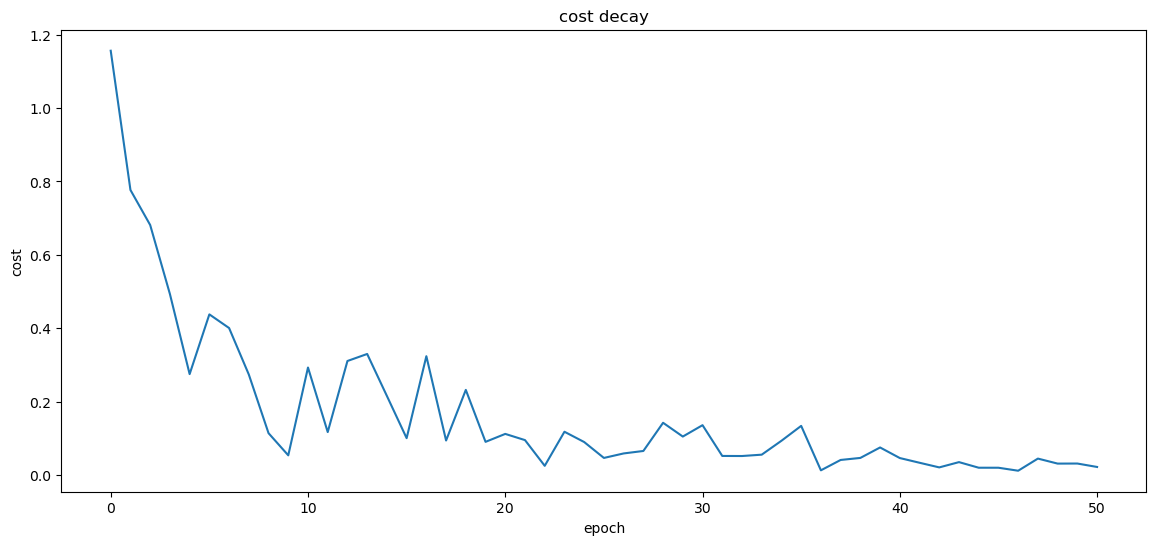

In [80]:
epoch = 50
model =  MLP_Model()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam( model.parameters(), lr=0.00003 )
training(epoch,model, loss, opt)

## Avaliando a efetividade do Modelo

In [82]:
with torch.no_grad():
    
    model.eval()
    
    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)
        
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
  
    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))        


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.96      0.97       958
           7       0.95      0.96      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Testes para otimizar o modelo

### Alterando o número de épocas  
  
epochs = 20 , lr=0.003 --> (precision,recall,f1-score) = (0.78,0.76,0.77)  
epochs = 25 , lr=0.003 --> (precision,recall,f1-score) = (0.88,0.88,0.88)  
epochs = 30 , lr=0.003 --> (precision,recall,f1-score) = (0.86,0.85,0.85)  
epochs = 50 , lr=0.003 --> (precision,recall,f1-score) = (0.89,0.89,0.88)  

### Alterando o valor do Learning rate e o número de épocas  
  
epochs = 50 , lr=0.00003 --> (precision,recall,f1-score) = (0.93,0.93,0.93)  
epochs = 60 , lr=0.00003 --> (precision,recall,f1-score) = (0.92,0.92,0.92)  
epochs = 70 , lr=0.00003 --> (precision,recall,f1-score) = (0.94,0.94,0.94)  
epochs = 100 , lr=0.00003 --> (precision,recall,f1-score) = (0.94,0.94,0.94)  

### Alterando os layers
    
epochs = 100 , lr=0.00003 , L1(28*28,40) L2(40,10) --> (precision,recall,f1-score) = (0.95,0.95,0.95)  
epochs = 100 , lr=0.00003 , L1(28*28,80) L2(80,40) L3(40,10) --> (precision,recall,f1-score) = (0.97,0.97,0.97)  


In [3]:
df = pd.read_json('Experimentos_MLP.json')
df

,epochs,learning_rate,layers,Dropout,shuffle,precision,recall,f1_score
0,20,0.00300,"[L1(28x28,20), L2(20,10)]",False,False,0.78,0.76,0.77
1,25,0.00300,"[L1(28x28,20), L2(20,10)]",False,False,0.88,0.88,0.88
2,30,0.00300,"[L1(28x28,20), L2(20,10)]",False,False,0.86,0.85,0.85
3,50,0.00300,"[L1(28x28,20), L2(20,10)]",False,False,0.89,0.89,0.88
4,50,0.00003,"[L1(28x28,20), L2(20,10)]",False,False,0.93,0.93,0.93
5,60,0.00003,"[L1(28x28,20), L2(20,10)]",False,False,0.92,0.92,0.92
6,70,0.00003,"[L1(28x28,20), L2(20,10)]",False,False,0.94,0.94,0.94
7,100,0.00003,"[L1(28x28,20), L2(20,10)]",False,False,0.94,0.94,0.94
8,100,0.00003,"[L1(28x28,40), L2(40,10)]",False,False,0.95,0.95,0.95
9,100,0.00003,"[L1(28x28,80), L2(80,40), L3(40,10)]",False,False,0.97,0.97,0.97


<Axes: xlabel='epochs', ylabel='precision'>

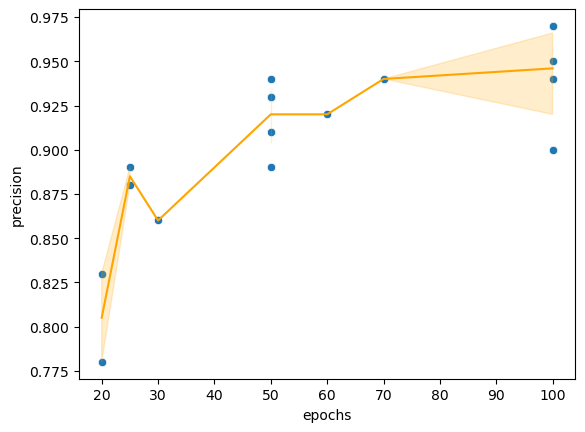

In [4]:
sns.scatterplot(data=df, x="epochs", y="precision")
sns.lineplot(data=df, x="epochs", y="precision", color='orange')  # Linha para mostrar tendência


<Axes: xlabel='learning_rate', ylabel='precision'>

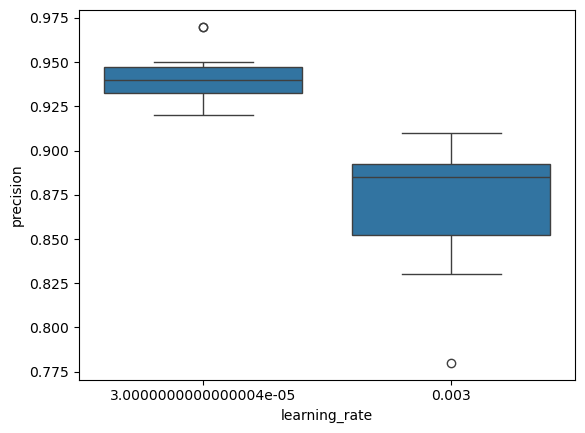

In [7]:
sns.boxplot(data=df, x="learning_rate", y="precision")




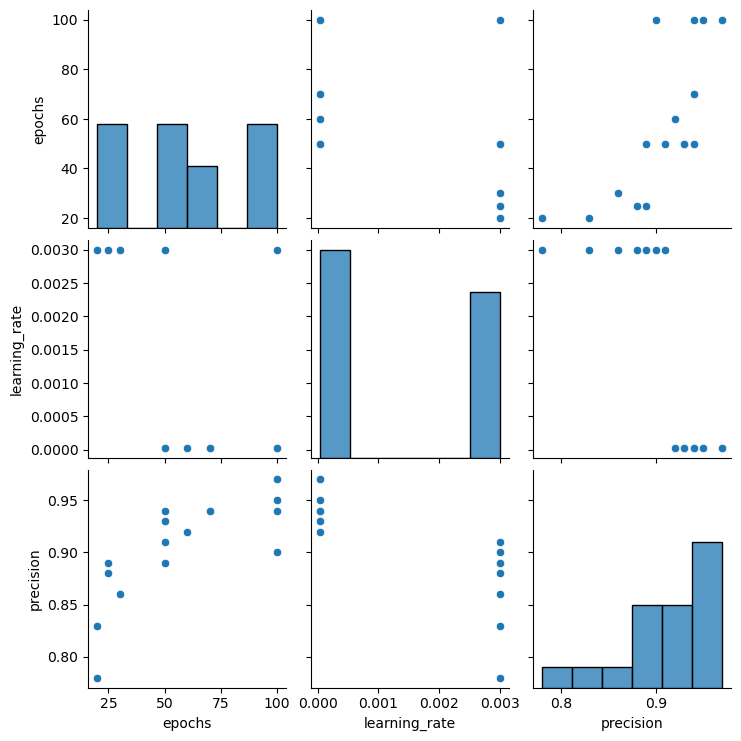

In [9]:
sns.pairplot(df, vars=["epochs", "learning_rate", "precision"])



# CNN

## Criando o Modelo CNN

In [ ]:
# criando o modelo da rede CNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader




# Criar uma classe que herda o modulo nn.Module

class MLP_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # transformar a entrada em um único tensor unidimensional

        self.Fl = nn.Flatten()
        
        # a primeira camada de convolução
        # o parâmetro in_channels é para identificar as dimensões que a representação da sua imagem possuí, ex RGB = 3, gray_scale = 1, ou os mapas de características dado por camadas anteriores
        # e o out_channels é para a saída gerada pela unidade computacional, maiores valores gerarão mais mapas de características
        # o kernel e o stride podem assumir valores diferentes, mas por fins de simplificação iremos apenas passar inteiros

        self.C1 = nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 4, stride = 1 )

        # após a operação de convolução, virá a operação de pooling
        # existem diferentes formas pela biblioteca para fazer a operação de pooling, mas utilizaremos o Max

        self.P1 = nn.MaxPool2d( kernel_size = 4)
        
        #segunda camada de convolução + pooling

        self.C2 = nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = 4, stride = 1)
        self.P2 = nn.MaxPool2d(kernel_size = 4)
        

        # Após n operações de convolução e pooling a imagem será achatada pela operação Flatten
        # e será usado em uma rede MLP
        # o pytorch não oferece maneiras dinâmicas de fazer alteração nos parâmetros da rede após a criação
        # então o valor das entradas e saídas após cada camada devem ser calculadas: output_size=((input_size−kernel_size+2×padding)/stride) + 1
        # para a primeira camada após a convolução temos output_size = 25
        # para a primeira camada após o pooling temos output_size =  22
        # para a segunda camada após a convolução temos output_size = 19
        # para a segunda camada após o pooling temos output_size = 16
        # então para a rede MLP teremos uma quantidade de entradas 16x16

        #primeira camada terá 100 unidades computacionais
        self.L1 = nn.Linear(10*16*16, 100)

        #segunda camada para 50 unidades computacionais
        self.L2 = nn.Linear(100, 50)

        #terceira camada para 10
        self.L3 = nn.Linear(50, 10)


    def forward(self, x):
        
        
        # primeira camada de convolução + função relu
        x = nn.relu(self.C1(x))
        
        # primeira camada de pooling
        x = self.P1(x)
        
        # segunda camada de convolução + função relu

        x = nn.relu(self.C2(x))

        # segunda camada de pooling

        x = self.P2(x)

        # a operação de achatamento

        x = self.Fl(x)

        # as 3 camadas da rede MLP + função relu
        
        x = nn.relu(self.L1(x))
        
        x = nn.relu(self.L2(x))

        x = self.L3(x)
        
        return x       
